# UE Localization Visualization

This notebook generates the core figures for the UE localization pipeline:
- setup and data loading
- input features and map layers
- predictions and metrics
- loss and refinement diagnostics
- summary dashboard


In [1]:
import sys
import os
from pathlib import Path
import yaml
import torch
import numpy as np
import pandas as pd
from IPython.display import display
import importlib

# Ensure matplotlib renders inline in notebooks
try:
    from IPython import get_ipython
    ip = get_ipython()
    if ip is not None:
        ip.run_line_magic('matplotlib', 'inline')
except Exception:
    pass
try:
    from matplotlib_inline.backend_inline import set_matplotlib_formats
    set_matplotlib_formats('png')
except Exception:
    pass

# Notebook verbosity control
VERBOSE = False

# Get the absolute path to project root
project_root = Path("/home/ubuntu/projects/MapConditionedPose")

if VERBOSE:
    print(f"Project root: {project_root}")

# Change to project root
os.chdir(project_root)

# Add src to path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Force deep reload of all src modules by removing them from cache first
to_remove = [key for key in sys.modules.keys() if key.startswith('src.')]
for key in to_remove:
    del sys.modules[key]

from src.training import UELocalizationLightning
# Note: collate_fn is now None (uses PyTorch default) for LMDB dataset



## 1. Load Model and Data

Load a trained checkpoint and point the config at a valid dataset path for visualization.


In [ ]:
# Resolve checkpoint + dataset paths
from src.notebook_plot_helpers import (
    resolve_checkpoint_and_config,
    resolve_lmdb_paths,
    load_model_and_batch,
)

CHECKPOINT_DIR = 'outputs'
CHECKPOINT_PATH = ''
CHECKPOINT_EPOCH = None

CHECKPOINT_PATH, BASE_CONFIG_PATH, ckpt_notes = resolve_checkpoint_and_config(
    checkpoint_dir=CHECKPOINT_DIR,
    checkpoint_path=CHECKPOINT_PATH,
    checkpoint_epoch=CHECKPOINT_EPOCH,
)
DATASET_PATH, TRAIN_PATH, VAL_PATH, TEST_PATH = resolve_lmdb_paths()

if VERBOSE:
    print(f'Checkpoint: {CHECKPOINT_PATH}')
    print(f'Config: {BASE_CONFIG_PATH}')
    print(f'Dataset: {DATASET_PATH}')
    if ckpt_notes:
        print('Notes:')
        for note in ckpt_notes:
            print(f'- {note}')
elif ckpt_notes:
    print(' | '.join(ckpt_notes))


In [ ]:
# Load model and build a batch
TARGET_BATCH_IDX = 1
model, batch, val_loader = load_model_and_batch(
    CHECKPOINT_PATH,
    BASE_CONFIG_PATH,
    TRAIN_PATH,
    VAL_PATH,
    TEST_PATH,
    target_batch_idx=TARGET_BATCH_IDX,
    verbose=VERBOSE,
)


In [ ]:
SAMPLE_IDX = 5 # Updated to Batch 6, Sample 0 (error ~5.4m)


if 'batch' not in globals():
    raise RuntimeError('batch not defined; run the setup cell above')

SCENE_ID = None
SCENE_IDX = None
GLOBAL_SAMPLE_IDX = None
if 'scene_idx' in batch:
    try:
        SCENE_IDX = int(batch['scene_idx'][SAMPLE_IDX].item())
    except Exception:
        SCENE_IDX = None
if SCENE_IDX is not None and hasattr(val_loader, 'dataset'):
    meta = getattr(val_loader.dataset, '_metadata', None)
    if meta:
        scene_ids = meta.get('scene_ids')
        if scene_ids and 0 <= SCENE_IDX < len(scene_ids):
            SCENE_ID = scene_ids[SCENE_IDX]
if SCENE_ID is not None and 'TARGET_BATCH_IDX' in globals() and hasattr(val_loader, 'batch_size'):
    try:
        bs = int(val_loader.batch_size) if val_loader.batch_size is not None else None
        if bs is not None:
            if hasattr(val_loader.dataset, '_indices') and val_loader.dataset._indices is not None:
                idx_list = val_loader.dataset._indices
                base = TARGET_BATCH_IDX * bs + SAMPLE_IDX
                if 0 <= base < len(idx_list):
                    GLOBAL_SAMPLE_IDX = idx_list[base]
            else:
                GLOBAL_SAMPLE_IDX = TARGET_BATCH_IDX * bs + SAMPLE_IDX
    except Exception:
        GLOBAL_SAMPLE_IDX = None
if VERBOSE and SCENE_ID is not None:
    print(f"Scene ID: {SCENE_ID} (scene_idx={SCENE_IDX})")

sample_idx = SAMPLE_IDX
measurements = batch['measurements']

B = measurements['cell_ids'].shape[0]
L = measurements['cell_ids'].shape[1]

rt_key = 'rt_features' if 'rt_features' in measurements else 'rt'
phy_key = 'phy_features' if 'phy_features' in measurements else 'phy'
mac_key = 'mac_features' if 'mac_features' in measurements else 'mac'

rt_dim = measurements[rt_key].shape[-1] if rt_key in measurements else None
phy_dim = measurements[phy_key].shape[-1] if phy_key in measurements else None
mac_dim = measurements[mac_key].shape[-1] if mac_key in measurements else None
has_cfr = 'cfr' in measurements

valid_seq_len = int(measurements['mask'][sample_idx].sum().item())

if VERBOSE:
    print(
        f"Input dims: B={B}, L={L}, RT={rt_dim}, PHY={phy_dim}, MAC={mac_dim}, CFR={'yes' if has_cfr else 'no'}"
    )
    print(f"Valid timesteps (sample {sample_idx}): {valid_seq_len}")


In [ ]:
# Plot helpers moved to src/notebook_plot_helpers.py
from src.notebook_plot_helpers import (
    visualize_all_features,
    visualize_maps,
    visualize_lidar_height,
    plot_ue_tx_scatter,
    visualize_feature_histograms,
    diagnose_coarse_heatmap,
    list_available_scenes,
    visualize_sionna_3d_scene,
    visualize_radio_map_3d_fallback,
    render_prediction,
    compute_evaluation_metrics,
    plot_error_analysis,
    compute_loss_breakdown,
    visualize_coarse_heatmap,
    visualize_fine_refinement,
    demonstrate_bilinear_resampling,
    visualize_bilinear_sampling,
    compute_physics_loss_demo,
    demonstrate_position_refinement,
    visualize_refinement,
    create_summary_visualization,
    plot_ue_trajectories,
)


## 2. Input Features Overview

RadioEncoder ingests temporal RT/PHY/MAC measurements plus IDs and optional CFR.


In [ ]:
# Summary tables for RT/PHY/MAC inputs
visualize_all_features(batch, sample_idx=SAMPLE_IDX, model=model, verbose=VERBOSE)


## 3. Input Feature Table

All RadioEncoder inputs for one sample (normalized).

| Layer | Features | Source |
|-------|----------|--------|
| **RT** | ToA, RMS-DS, RMS-AS, total power, # significant paths, NLOS (plus unused slots) | Sionna ray tracing |
| **PHY** | RSRP, RSRQ, SINR, CQI, RI, PMI, best beam ID | PHY layer |
| **MAC** | Serving cell, neighbor IDs, timing advance, DL throughput, BLER | MAC/RRC |
| **IDs** | Cell ID, beam ID, timestamp | Categorical/temporal |

Note: CFR is no longer part of the encoder inputs.


In [ ]:
# Build a dataframe of normalized feature inputs for the selected sample
from src.config.feature_schema import RTFeatureIndex, PHYFeatureIndex, MACFeatureIndex

def _to_np(value):
    if torch.is_tensor(value):
        return value.detach().cpu().numpy()
    return np.asarray(value)

def build_feature_dataframe(measurements, sample_idx, mask=None):
    rt = measurements.get(rt_key)
    phy = measurements.get(phy_key)
    mac = measurements.get(mac_key)
    if rt is None or phy is None or mac is None:
        raise RuntimeError('Missing RT/PHY/MAC tensors in measurements')

    rt = _to_np(rt[sample_idx])
    phy = _to_np(phy[sample_idx])
    mac = _to_np(mac[sample_idx])

    cell_ids = measurements.get('cell_ids')
    beam_ids = measurements.get('beam_ids') or measurements.get('beam_id')
    timestamps = measurements.get('timestamps')
    if cell_ids is not None:
        cell_ids = _to_np(cell_ids[sample_idx])
    if beam_ids is not None:
        beam_ids = _to_np(beam_ids[sample_idx])
    if timestamps is not None:
        timestamps = _to_np(timestamps[sample_idx])

    if mask is None and 'mask' in measurements:
        mask = _to_np(measurements['mask'][sample_idx])

    rt_map = {
        'rt_toa': RTFeatureIndex.TOA,
        'rt_rms_delay_spread': RTFeatureIndex.RMS_DELAY_SPREAD,
        'rt_rms_angular_spread': RTFeatureIndex.RMS_ANGULAR_SPREAD,
        'rt_total_power': RTFeatureIndex.TOTAL_POWER,
        'rt_n_significant_paths': RTFeatureIndex.N_SIGNIFICANT_PATHS,
        'rt_is_nlos': RTFeatureIndex.IS_NLOS,
    }
    phy_map = {
        'phy_rsrp': PHYFeatureIndex.RSRP,
        'phy_rsrq': PHYFeatureIndex.RSRQ,
        'phy_sinr': PHYFeatureIndex.SINR,
        'phy_cqi': PHYFeatureIndex.CQI,
        'phy_ri': PHYFeatureIndex.RI,
        'phy_pmi': PHYFeatureIndex.PMI,
        'phy_best_beam_id': PHYFeatureIndex.BEST_BEAM_ID,
    }
    mac_map = {
        'mac_serving_cell_id': MACFeatureIndex.SERVING_CELL_ID,
        'mac_neighbor_cell_id_1': MACFeatureIndex.NEIGHBOR_CELL_ID_1,
        'mac_neighbor_cell_id_2': MACFeatureIndex.NEIGHBOR_CELL_ID_2,
        'mac_timing_advance': MACFeatureIndex.TIMING_ADVANCE,
        'mac_dl_throughput': MACFeatureIndex.DL_THROUGHPUT,
        'mac_bler': MACFeatureIndex.BLER,
    }

    rows = []
    seq_len = rt.shape[0]
    num_cells = rt.shape[1]
    for t in range(seq_len):
        if mask is not None and t < len(mask) and mask[t] == 0:
            continue
        for c in range(num_cells):
            row = {
                'timestep': t,
                'cell_idx': c,
                'mask': float(mask[t]) if mask is not None and t < len(mask) else 1.0,
            }
            if cell_ids is not None and cell_ids.ndim >= 2:
                row['cell_id'] = float(cell_ids[t, c])
            if beam_ids is not None:
                if beam_ids.ndim >= 2:
                    row['beam_id'] = float(beam_ids[t, c])
                elif beam_ids.ndim == 1:
                    row['beam_id'] = float(beam_ids[t])
            if timestamps is not None:
                if timestamps.ndim >= 1:
                    row['timestamp_s'] = float(timestamps[t])

            for name, idx in rt_map.items():
                row[name] = float(rt[t, c, idx])
            for name, idx in phy_map.items():
                row[name] = float(phy[t, c, idx])
            for name, idx in mac_map.items():
                row[name] = float(mac[t, c, idx])
            rows.append(row)

    return pd.DataFrame(rows)

feature_df = build_feature_dataframe(measurements, SAMPLE_IDX)
display(feature_df.head(20))
print(f'Total rows: {len(feature_df)} (timestep x cells for sample {SAMPLE_IDX})')


## Feature Distributions

Histograms for all model input features to sanity-check ranges.


In [ ]:
# Plot helpers moved to src/notebook_plot_helpers.py

visualize_feature_histograms(batch, max_dims=12)


## 4. Map Layers

10-channel map input to the MapEncoder.

Radio map (5 channels): RSRP, RSRQ, SINR, CQI, throughput.
OSM map (5 channels): height, material, footprint, road, terrain.


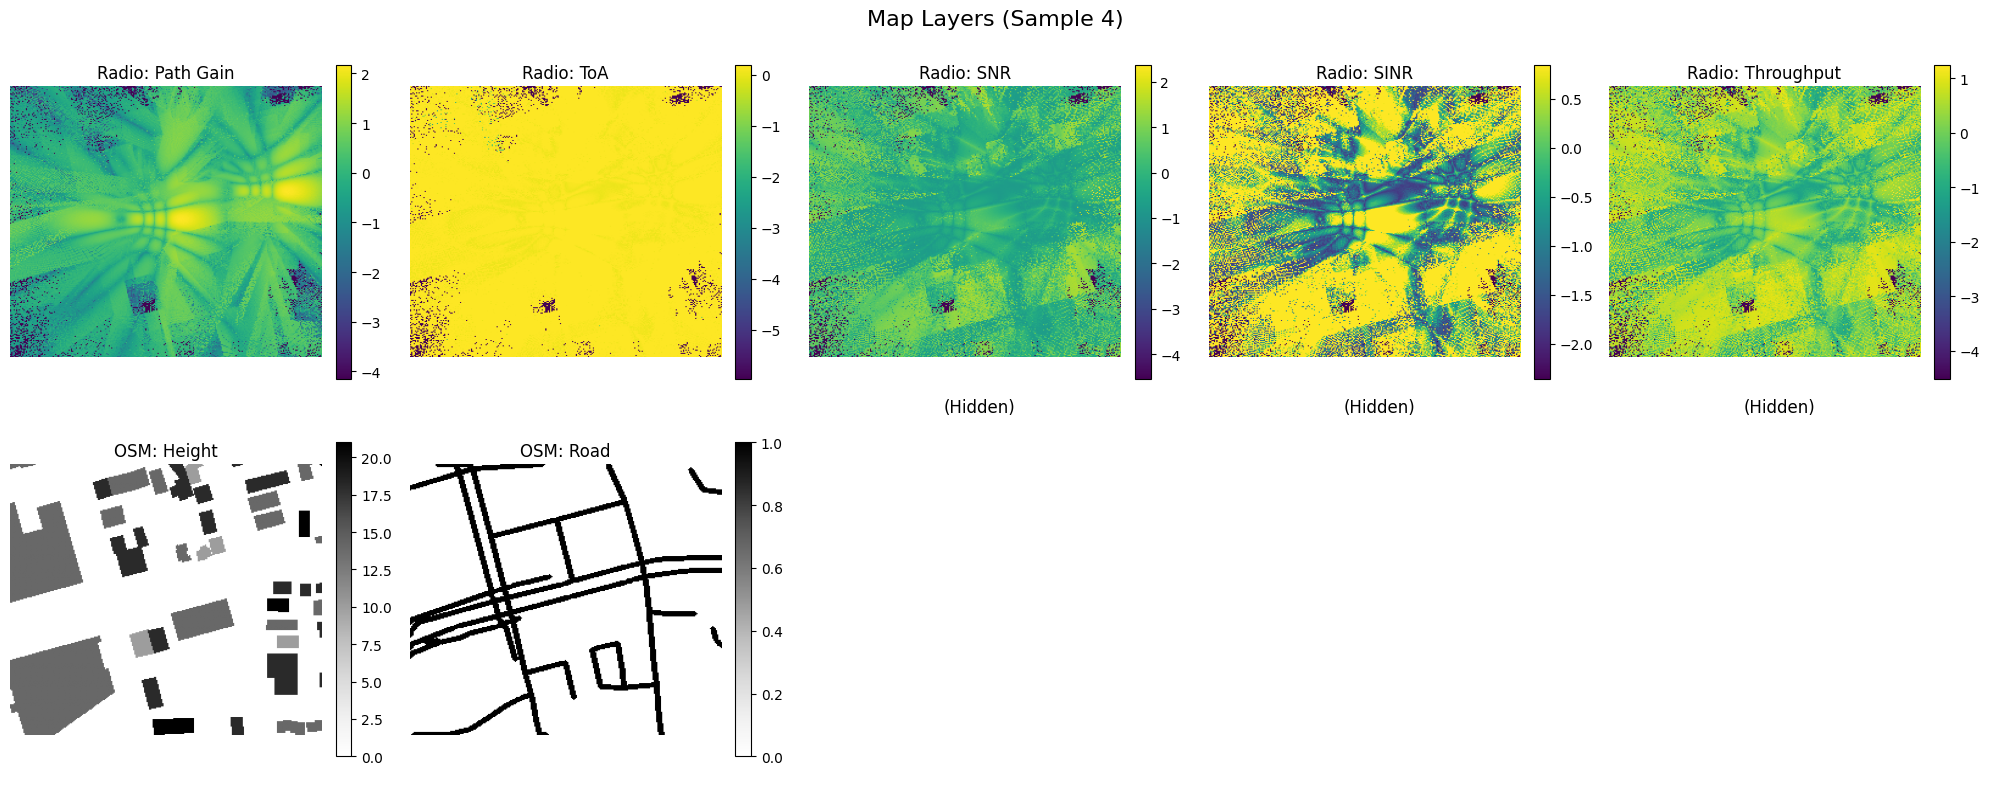

In [ ]:
# Plot helpers moved to src/notebook_plot_helpers.py

visualize_maps(batch, sample_idx=SAMPLE_IDX)


### LiDAR Height (after Map Layers)

OSM channel 0 shows the LiDAR-derived height map used for terrain context.


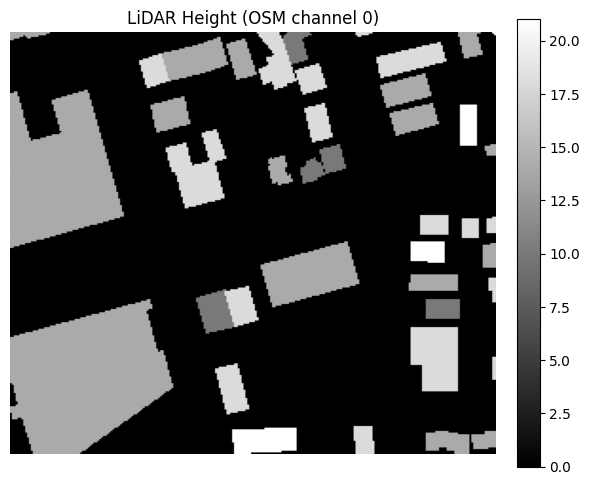

In [ ]:
# Plot helpers moved to src/notebook_plot_helpers.py

visualize_lidar_height(batch, sample_idx=SAMPLE_IDX, save_path="docs/paper/figures/lidar_height.png")


### UE and TX Locations


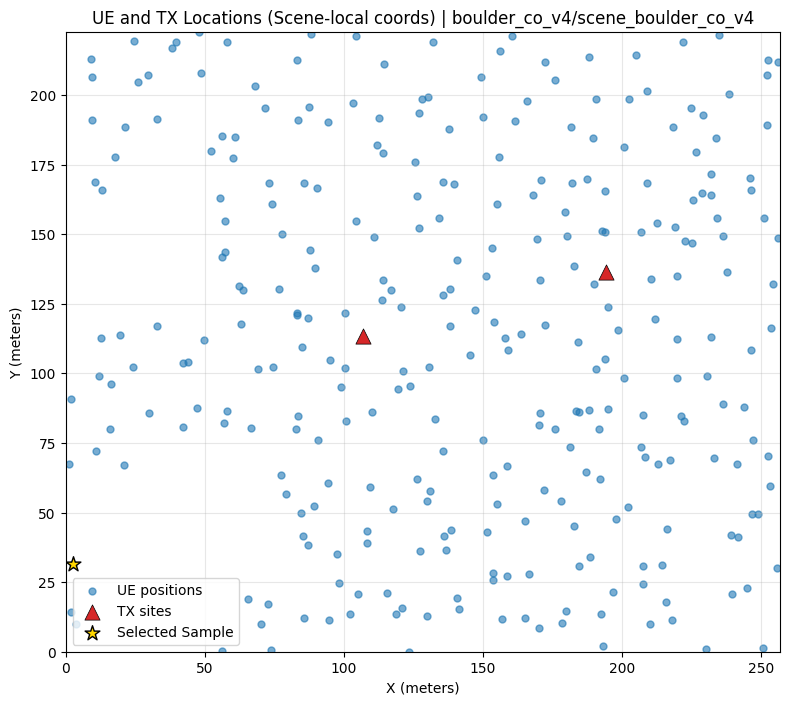

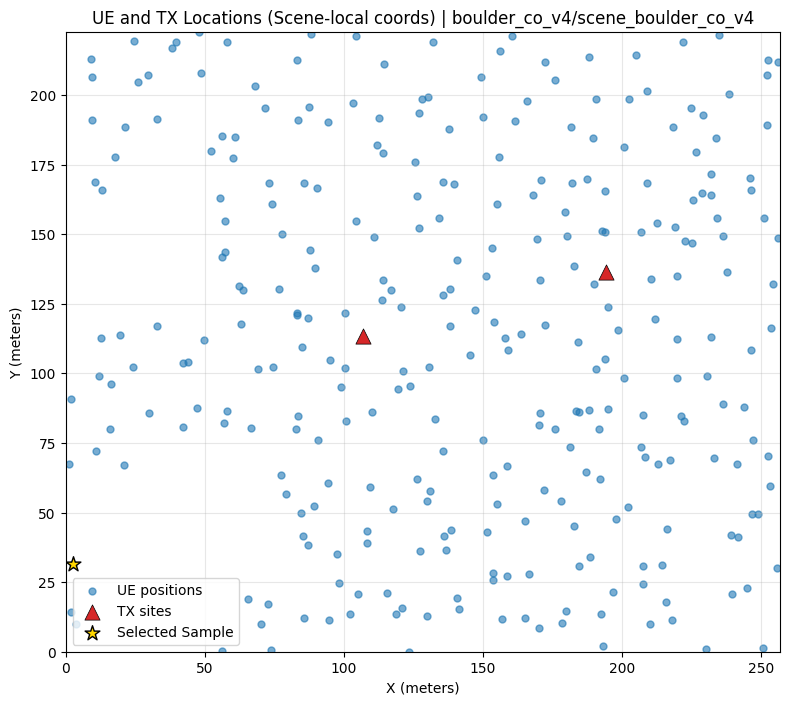

In [ ]:
# Plot helpers moved to src/notebook_plot_helpers.py

plot_ue_tx_scatter(val_loader.dataset, coord_mode="auto", ue_size=25, ue_alpha=0.6, tx_size=120, scene_id_filter=SCENE_ID, highlight_sample_idx=GLOBAL_SAMPLE_IDX)


### UE Trajectories


In [ ]:
# Plot helpers moved to src/notebook_plot_helpers.py

plot_ue_trajectories(
    val_loader.dataset,
    num_trajectories=12,
    split=val_loader.dataset.split if hasattr(val_loader, "dataset") else "all",
    scene_id_filter=SCENE_ID,
    coord_mode="auto",
    save_path="docs/paper/figures/ue_trajectories.png",
)


### Map Checks
- Radio map should decay from transmitters with shadowing behind buildings.
- OSM height/roads should align with building geometry.
- If maps are uniform or misaligned, verify scene loading and coordinate transforms.


## 5. 3D Scene Visualization

Interactive Sionna render of geometry, radio map overlay, transmitters, and the selected UE.

Precomputed renders live in `outputs/*/visualizations/3d/3d_visualizations/`.
Use `scene_name` to force a specific scene.


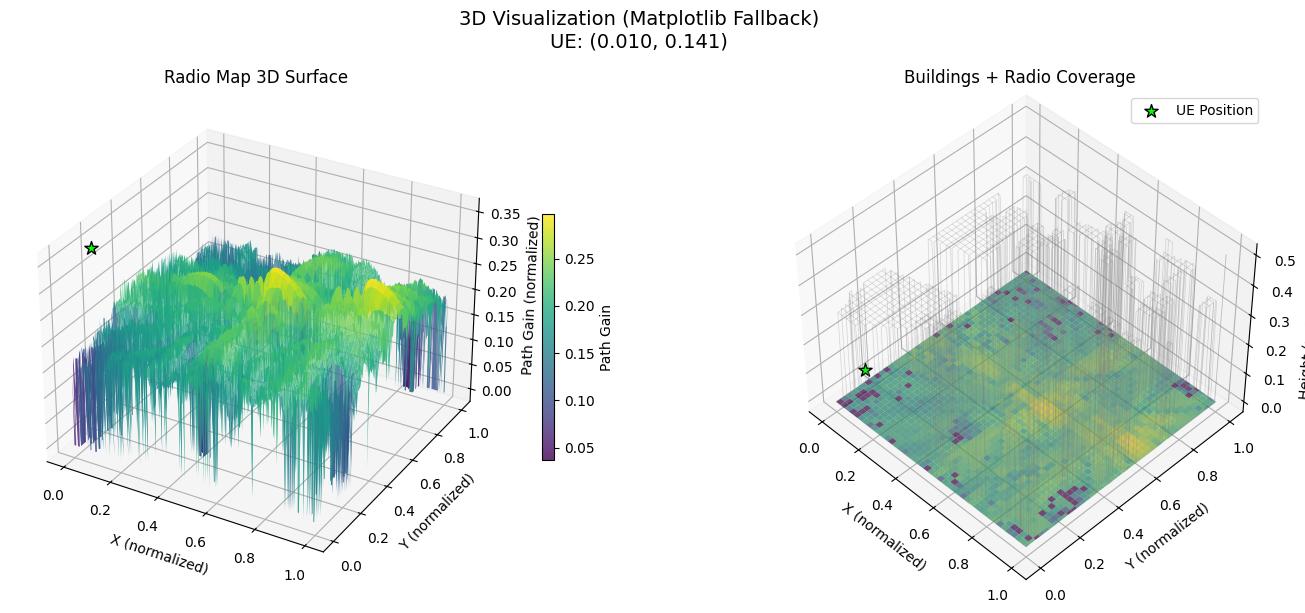

In [ ]:
# Plot helpers moved to src/notebook_plot_helpers.py

available = list_available_scenes()
if VERBOSE:
    print(f"Available scenes: {list(available.keys())}")

sionna_radio_map = visualize_sionna_3d_scene(batch, sample_idx=SAMPLE_IDX, scene_name=SCENE_ID, verbose=VERBOSE, use_sionna=False)


### 3D Scene Checks
- Buildings, transmitters, and UE should sit inside the scene bounds.
- Radio map should show stronger signal near TXs and shadowing behind buildings.
- If geometry is missing, fall back to the matplotlib 3D view.


## 6. Predictions vs Ground Truth

Top-K re-ranked hypotheses over the map, with predicted soft mean (red x), best hypothesis (orange circle), and GT (green star).
Color/size reflect hypothesis weight (softmax over coarse heatmap prior + fine score).


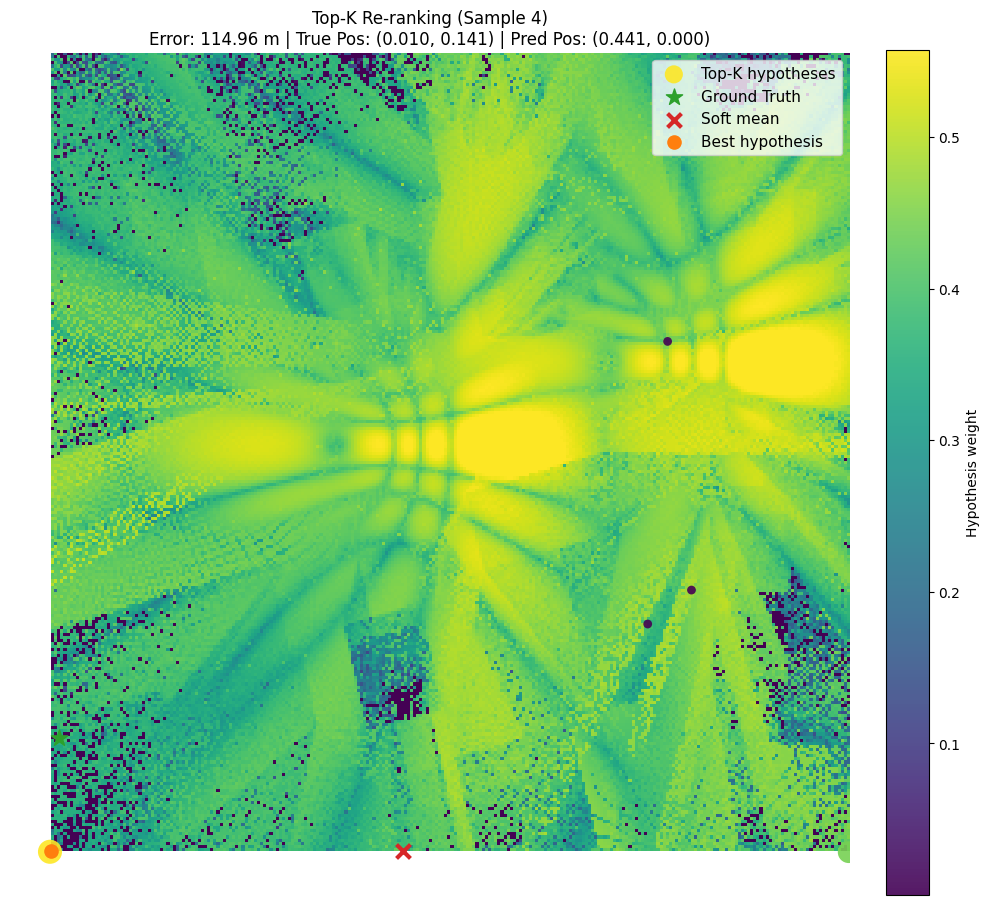

In [ ]:
# Plot helpers moved to src/notebook_plot_helpers.py

# Use a sample with position more in the center for better visualization
outputs = render_prediction(model, batch, sample_idx=SAMPLE_IDX, verbose=VERBOSE)


### Prediction Checks
- Heatmap peak should be near GT; multi-modal peaks indicate ambiguity.
- Errors < 10 m are strong; > 50 m suggests model or data issues.
- Flat heatmaps usually mean collapse or poor training.


### Re-ranking Weights (Code Changes)
- FineHead predicts offset + score per Top-K cell (no sigma).
- Hypothesis weights = softmax(log(p_coarse) + score), where p_coarse comes from the coarse heatmap Top-K.
- Fine loss = expected Smooth-L1 error under these weights (not an NLL).
Note: the current checkpoint predates these changes; retrain to see the effect.


## 7. Evaluation Metrics

Histogram, CDF, and box plot for localization error. Metrics reported: mean, median, RMSE, and percentiles.


In [ ]:
# Plot helpers moved to src/notebook_plot_helpers.py

metrics, errors_m, pred_pos, true_pos, scene_extent = compute_evaluation_metrics(model, batch)

metric_str = ", ".join([
    f"mean={metrics['Mean Error (m)']:.2f} m",
    f"median={metrics['Median Error (m)']:.2f} m",
    f"rmse={metrics['RMSE (m)']:.2f} m",
    f"p90={metrics['90th Percentile (m)']:.2f} m",
])
print(f"Metrics: {metric_str} | sample error={errors_m[SAMPLE_IDX]:.2f} m")


Metrics: mean=108.54 m, median=114.90 m, rmse=115.62 m, p90=155.71 m | sample error=165.22 m


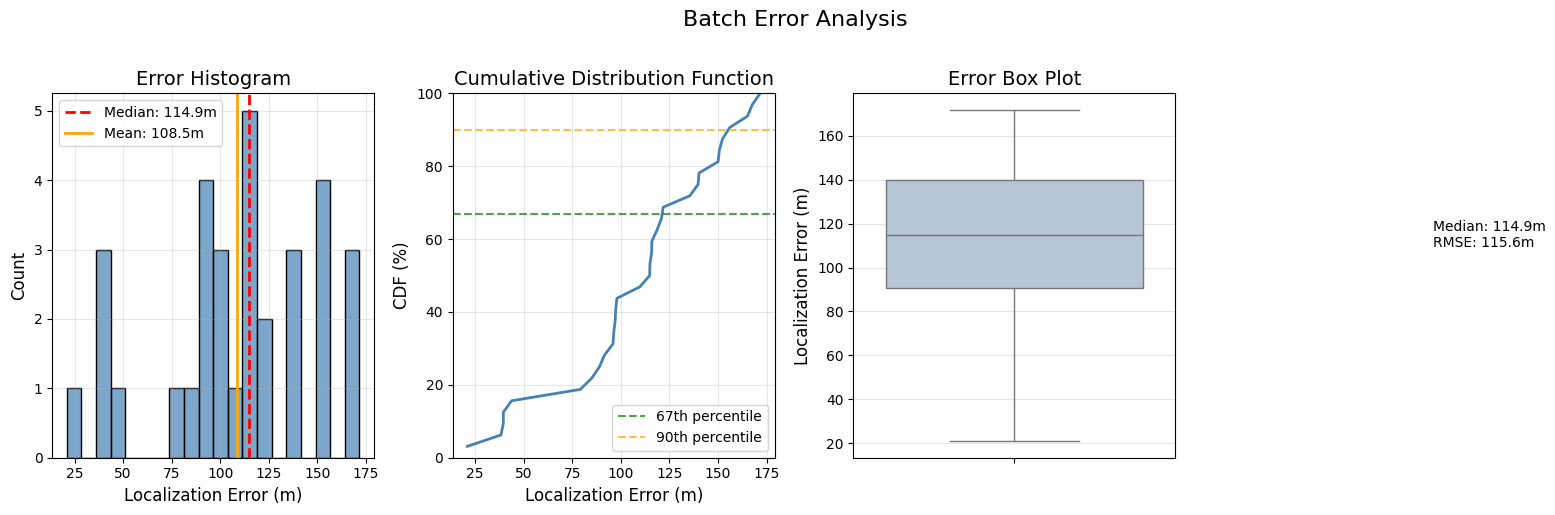

In [ ]:
# Plot helpers moved to src/notebook_plot_helpers.py

# Plot error analysis for the batch
plot_error_analysis(errors_m, "Batch Error Analysis")

### Metric Checks
- Median should be lower than mean (right-skew expected).
- CDF should rise steeply at low errors; flat CDF suggests poor learning.
- Large outliers can indicate data or coordinate issues.


## 8. Coarse-to-Fine Loss

Coarse heatmap and top-k probabilities. Total loss:
$$\mathcal{L}_{\text{total}} = \lambda_{\text{coarse}} \mathcal{L}_{\text{coarse}} + \lambda_{\text{fine}} \mathcal{L}_{\text{fine}}$$
Fine loss is expected Smooth-L1 under the re-ranking weights (no mixture density term).


Loss (total/coarse/fine): 9.1094 / 8.9415 / 0.1679


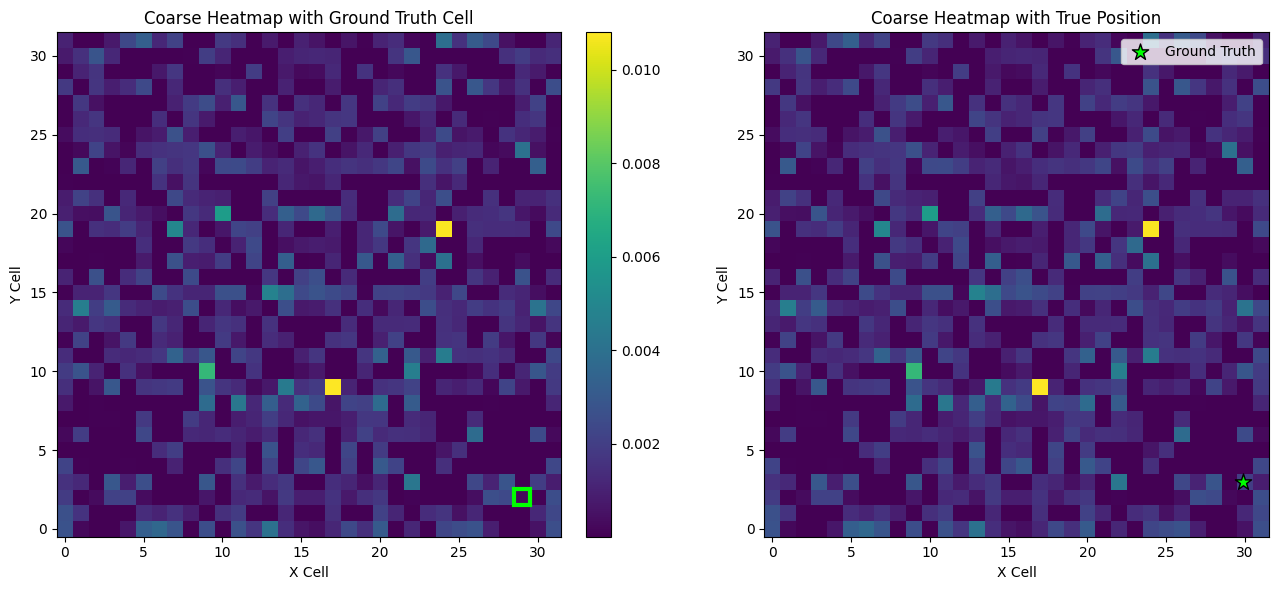

COARSE HEATMAP DIAGNOSTICS
Entropy: 6.307 (max 6.931)
GT cell (dataset): 93 -> (row 2, col 29)
GT cell (from position): 93 -> (row 2, col 29)
Pred peak: (row 9, col 17)


In [ ]:
# Plot helpers moved to src/notebook_plot_helpers.py

losses, outputs = compute_loss_breakdown(model, batch)
print(f"Loss (total/coarse/fine): {losses['loss'].item():.4f} / {losses['coarse_loss'].item():.4f} / {losses['fine_loss'].item():.4f}")

visualize_coarse_heatmap(outputs, batch, sample_idx=SAMPLE_IDX)

# Diagnostics

diagnose_coarse_heatmap(outputs, batch, sample_idx=SAMPLE_IDX)


### Loss Checks
- Coarse loss should be modest (< 2) and peak near the GT cell.
- Fine loss (expected Smooth-L1) should be reasonable and not dominate the total.
- Uniform coarse heatmaps indicate collapse or undertraining.


## 9. Fine Refinement Head

Offsets and per-candidate scores for Top-K hypotheses (no sigma/ellipses).


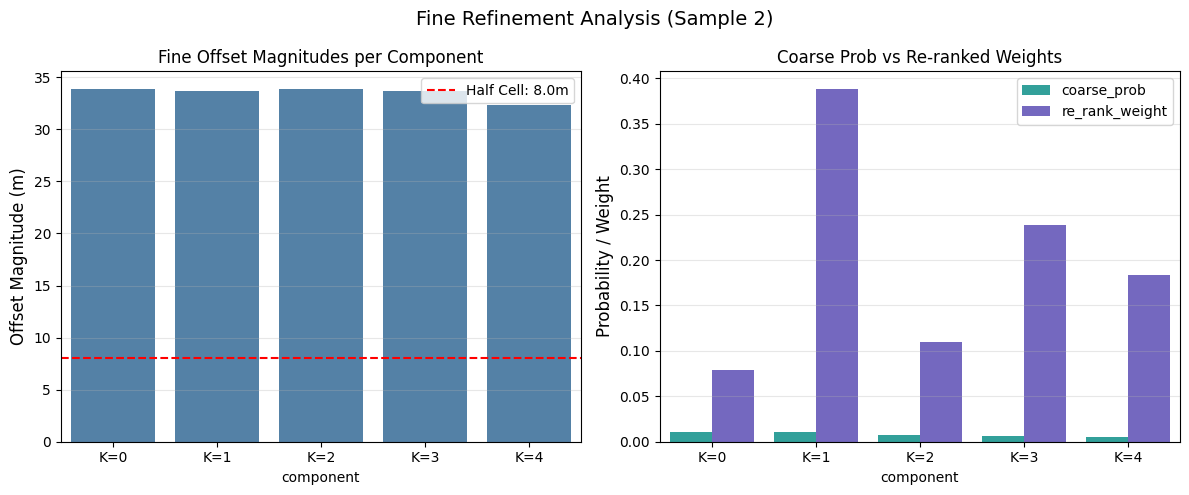

In [ ]:
# Plot helpers moved to src/notebook_plot_helpers.py

visualize_fine_refinement(outputs, batch, model=model, sample_idx=SAMPLE_IDX, verbose=VERBOSE)

### Refinement Checks
- Offsets should be within the cell; scores should prefer plausible candidates.
- Weights should be peaked when confident, but may remain multi-modal.
- Flat weights or large offsets suggest uncertainty or mismatch.


## 10. Physics Loss and Bilinear Sampling

Bilinear resampling supports differentiable feature lookup:
$$\mathcal{L}_{\text{phys}} = \sum_f w_f \| m_f^{\text{obs}} - R_f(\hat{\mathbf{x}}) \|^2$$


In [ ]:
# Plot helpers moved to src/notebook_plot_helpers.py

sampled_features, radio_map_sample = demonstrate_bilinear_resampling(batch, sample_idx=SAMPLE_IDX, verbose=VERBOSE)

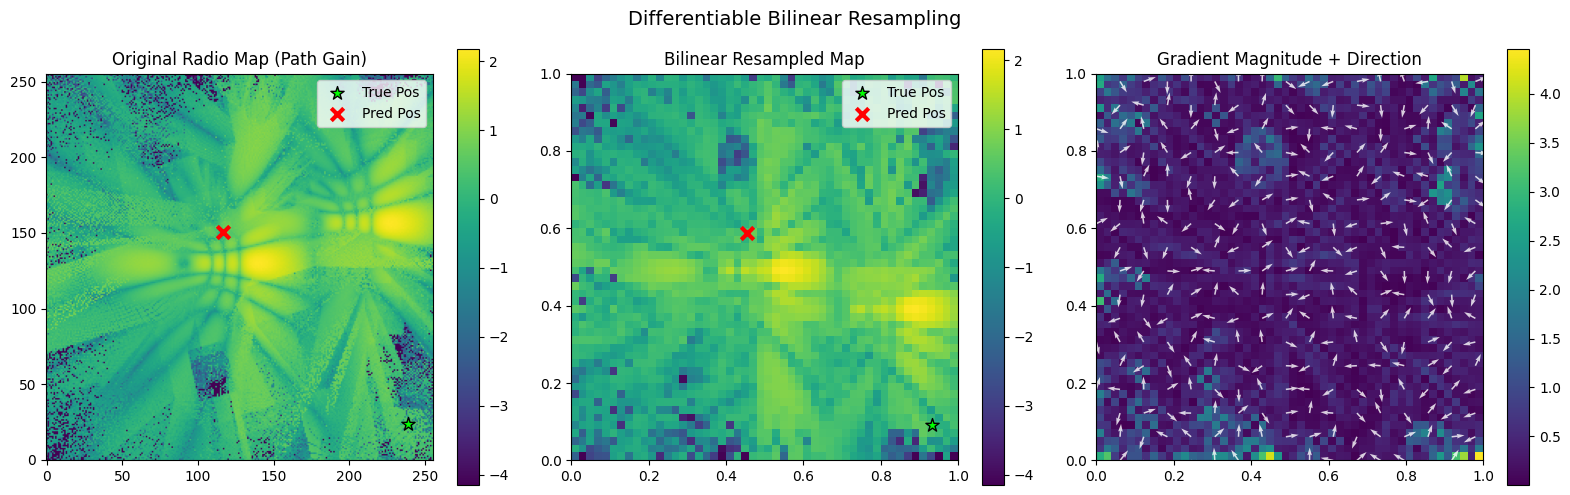

In [ ]:
# Plot helpers moved to src/notebook_plot_helpers.py

visualize_bilinear_sampling(batch, outputs, sample_idx=SAMPLE_IDX)

### Bilinear Sampling Checks
- Resampled map should be smooth; gradients strongest at edges.
- Gradients should point toward higher signal regions.
- Discontinuities imply interpolation or coordinate issues.


In [ ]:
# Plot helpers moved to src/notebook_plot_helpers.py

physics_loss_pred, physics_loss_gt = compute_physics_loss_demo(batch, outputs, sample_idx=SAMPLE_IDX, verbose=VERBOSE)

## 11. Inference-Time Refinement

Optimize position with physics loss. A density prior is optional; it is disabled when no hypothesis density (e.g., GMM) is provided:
$$E(\mathbf{y}) = \mathcal{L}_{\text{phys}}(\mathbf{y})$$


In [ ]:
# Plot helpers moved to src/notebook_plot_helpers.py

initial_pos, refined_pos, initial_errors, refined_errors = demonstrate_position_refinement(batch, outputs, sample_idx=SAMPLE_IDX, model=model, verbose=VERBOSE)


### Physics Loss Checks
- Loss at GT should be near zero and lower than at prediction.
- Large GT loss suggests map/measurement mismatch.
- Similar losses at GT and prediction indicate weak physics signal.


/home/ubuntu/projects/MapConditionedPose/src/notebook_plot_helpers.py:1752: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_err, x='stage', y='error_m', palette=['coral', 'steelblue'], ax=ax)


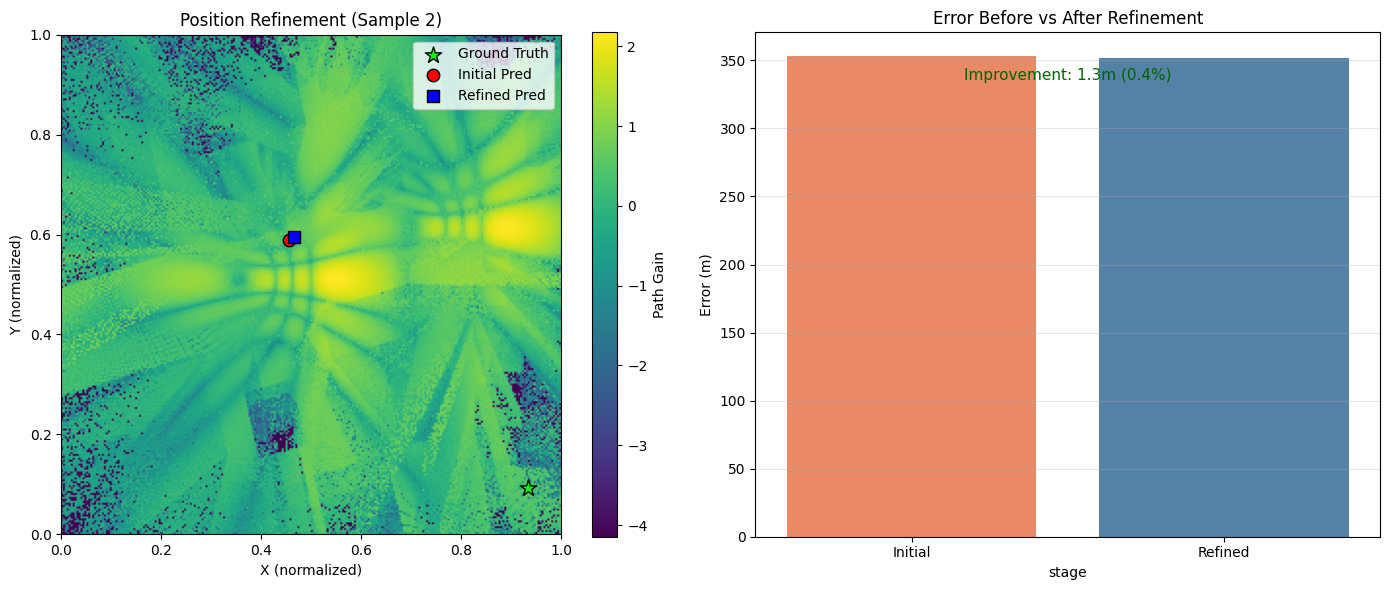

In [ ]:
# Plot helpers moved to src/notebook_plot_helpers.py

visualize_refinement(batch, initial_pos, refined_pos, sample_idx=SAMPLE_IDX)

### Refinement Checks
- Trajectory should move toward GT and reduce error.
- Divergence or no improvement suggests step size or weighting issues.


### Optimization Update

Gradient descent update:
$$\hat{\mathbf{x}}_{t+1} = \hat{\mathbf{x}}_t - \eta \nabla_{\mathbf{x}} \mathcal{L}_{\text{phys}}(\hat{\mathbf{x}}_t)$$


## 12. Summary Dashboard

Combined view of metrics, losses, refinement gains, and model overview.


/home/ubuntu/projects/MapConditionedPose/src/notebook_plot_helpers.py:1885: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


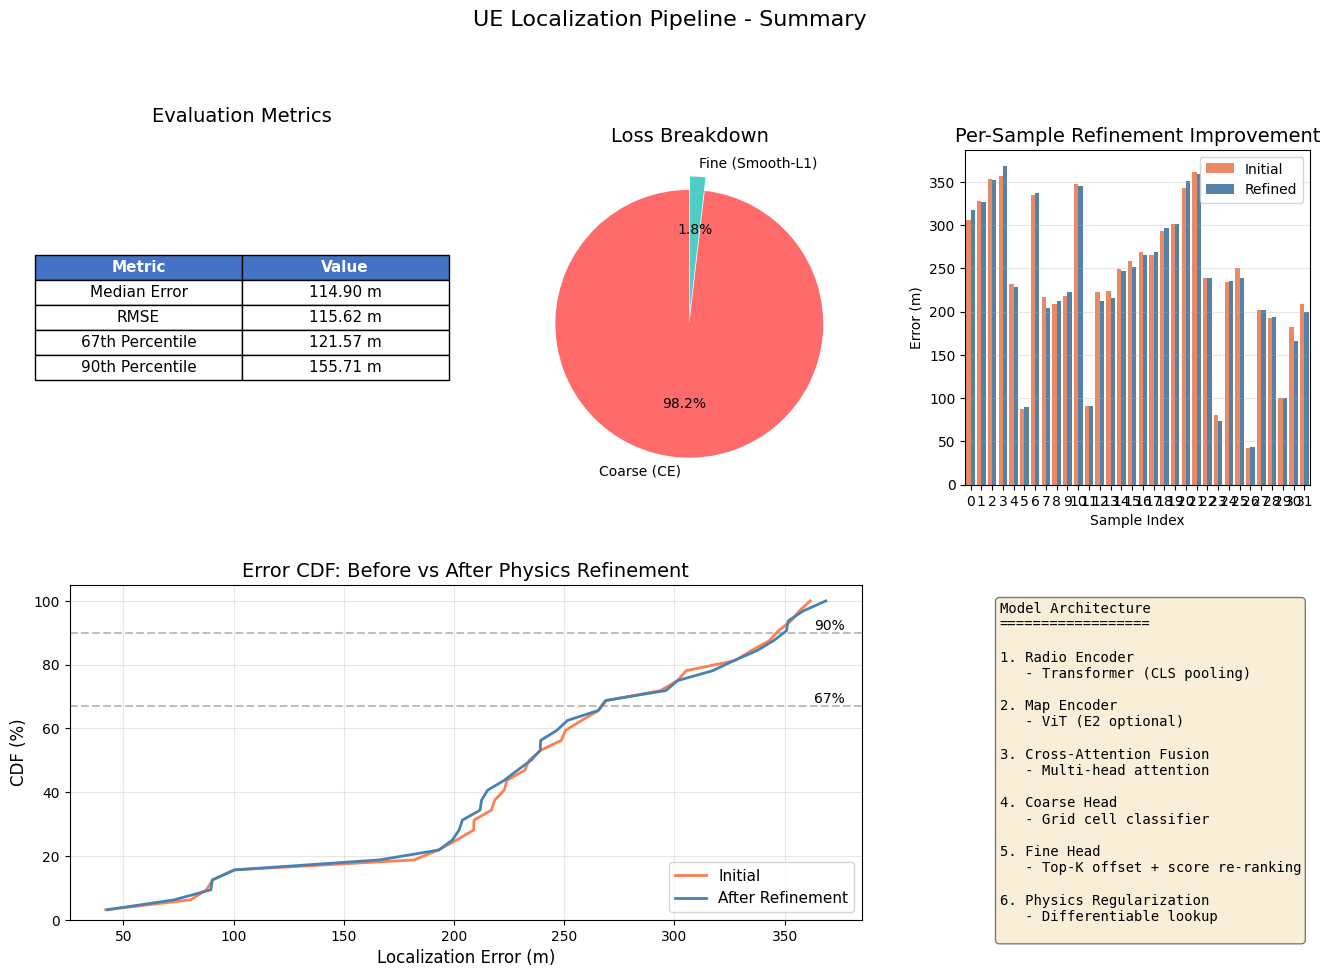

In [ ]:
# Plot helpers moved to src/notebook_plot_helpers.py

# Create final summary
create_summary_visualization(metrics, losses, initial_errors, refined_errors)

### Summary Checks
- Metrics and visuals should tell a consistent story.
- Refinement should improve or maintain accuracy.
- If results are poor, re-check data quality and training.
